# Telecom Churn Prediction Case Study

**Author:** Abhishek Mukherjee , Vaibhav Singh Chauhan

# Content
- Problem Statement
- Loading Datasets and Libraries
- Create X, y and then Train test split
- Handling Missing Value and Duplicated data
- Exploratory Data Analysis & Preprocessing
- Feature Engineering and Selection
- Model Building and Baselining
- Model evaluation, Selection and Prediction

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we are expected analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, our goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*



# 1. Loading Datasets and Libraries

Lets start by loading required libraries. We can keep adding any imports to this cell block, as we write mode and mode code.

In [103]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Class Imbalance handling
from imblearn.over_sampling import SMOTE

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, we will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that we are working with, which will help in analyzing which features might impact the churn rate of a user, and what sort of analysis could be done to understand the distribution of the feature better.

In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
# Setting the maximum columns and rows display
pd.set_option("display.max_columns",300)
pd.set_option("display.max_rows",500)

In [5]:
# Lets see the train data
data.head() 

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [6]:
# Set index as id
data = data.set_index('id')
data.head()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708   

     arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
id                                                                          
0    87.009    7.527        48.58       124.38         1.29         32.24   
1   122.787   42.953         0.00         0.00         0.00          0.00   
2   103.176    0.000         0.53        15.93         0.00         53.99   
3   205.260  111.095         7.26        16.01         0.00         68.76   
4   128.191  101.565        21.28         4.83         6.13         56.99   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                            
0          96.68          2.33           0.00            0.0            0.0   
1          25.99         30.89           0.00            0.0            0.0   
2          82.05          0.00           0.00            0.0            0.0   
3          78.48         50.23           0.00            0.0            0.0   
4          38.11          9.63          53.64            0.0            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                  
0            0.00            0.0           0.00              2.23   
1            0.00            0.0           0.00              0.00   
2            0.00            0.0           0.00              0.53   
3            0.00            0.0           1.63              6.99   
4           15.73            0.0           0.00             10.16   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                           
0               0.00              0.28              5.29             16.04   
1               0.00              0.00              0.00              0.00   
2              12.98              0.00             24.11              0.00   
3               3.94              0.00             37.91             44.89   
4               4.83              6.13             36.74             19.88   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                           
0               2.33              0.00              0.00              0.00   
1               0.00              0.00              0.00              0.00   
2               0.00              0.00              0.00              0.00   
3              23.63              0.00              0.00              0.00   
4               4.61             11.99              1.23              5.01   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                       
0               0.00              0.00              0.00          7.53   
1               0.00             22.01             29.79          0.00   
2               2.14             

In [7]:
# Lets get information on the dataset
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam_og_m

In [8]:
# Lets get some summary statistics with some basic outliers analysis
# Including data at various percentiles as well
data.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    69999.0         69297.0         69297.0         69297.0   
mean       109.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min        109.0             0.0             0.0             0.0   
25%        109.0             0.0             0.0             0.0   
50%        109.0             0.0             0.0             0.0   
75%        109.0             0.0             0.0             0.0   
90%        109.0             0.0             0.0             0.0   
95%        109.0             0.0             0.0             0.0   
99%        109.0             0.0             0.0             0.0   
max        109.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
90%      619.993800    615.661400    614.994600    345.080000    347.908000   
95%      832.022700    823.236700    828.464700    617.185000    628.437500   
99%     1400.276640   1414.891380   1445.054800   1447.098000   1478.540900   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.765435   
std      311.896596    316.818355    322.482226    324.089234      57.374429   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
90%      343.695000    482.030000    482.071000    486.980000      11.950000   
95%      620.240000    735.985000    747.558000    738.017500      41.350000   
99%     1472.480500   1546.471000   1545.104000   1522.474000     219.649000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   67312.000000   66296.000000   67231.000000   67312.000000   
mean        7.014568       7.004892      14.186457       9.842191   
std        55.960985      53.408135      73.469261      58.511894   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         5.039000       5.210000      22.710000       9.900000   
95%        23.199000      23.990000      69.455000      42.599000   
99%       153.006700     159.714000     290.851000     221.866800   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.771783         46.904854         46.166503         45.686109   
std        64.618388        150.971758        154.739002        153.716880   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.660000          1.650000     

There seems to be outliers in the numerical data, so we need to remove them for model building stage (some models may be influenced by outliers and we don't want that to happen)

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [9]:
data['circle_id'].unique()

array([109])

In [10]:
# Create the X, y data

X = data.drop(['circle_id'], axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 169), (69999,))

**Splitting train and test data to avoid any contamination of the test data**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 169), (14000, 169), (55999,), (14000,))

In [12]:
X_train.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
63606             0.0             0.0             0.0            6/30/2014   
46094             0.0             0.0             0.0            6/30/2014   
42716             0.0             0.0             0.0            6/30/2014   
54324             0.0             0.0             0.0            6/30/2014   
53484             0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  \
id                                                                           
63606            7/31/2014            8/31/2014  109.004  352.270  181.747   
46094            7/31/2014            8/31/2014  461.752  298.124  465.264   
42716            7/31/2014            8/31/2014  678.630  507.652  335.927   
54324            7/31/2014            8/31/2014  131.200  118.830  101.846   
53484            7/31/2014            8/31/2014  397.645  375.069  550.051   

       onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
63606        11.31         3.19         0.00        154.28         68.93   
46094       113.98        82.64        27.84        344.14        146.69   
42716        50.53        68.96        59.53         81.39        150.56   
54324        37.49         6.24        16.78         96.06         84.18   
53484       418.73       315.44       411.58         65.09        102.99   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
63606         51.48            0.0            0.0            0.0   
46094         22.13            0.0            0.0            0.0   
42716        121.84            0.0            0.0            0.0   
54324         73.39            0.0            0.0            0.0   
53484        176.63            0.0            0.0            0.0   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
63606            0.0            0.0            0.0              6.56   
46094            0.0            0.0            0.0             13.93   
42716            0.0            0.0            0.0             50.53   
54324            0.0            0.0            0.0             37.49   
53484            0.0            0.0            0.0             12.44   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
63606              3.19              0.00             82.93             66.64   
46094              9.74              4.88            234.01             53.44   
42716             68.96             59.53             80.91            139.24   
54324              6.24             16.78             90.24             73.79   
53484              9.76             24.81             28.11             25.93   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                              
63606             50.28             28.96              2.28              0.58   
46094              9.66              0.00              0.00              0.00   
42716            121.84              0.00              0.00              0.00   
54324             64.04              5.81             10.38              0.00   
53484             22.66              0.00              0.00              0.00   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                          
63606              0.00               0.0              0.00        118.46   
46094              0.00        

# 3. Handling Missing & Duplicate Data

We will be imputing missing data approach only in X_train dataset and the imputed values learned from X_train dataset will be later applied to X_test dataset. This is an approach to help avoid contamination

<Axes: >

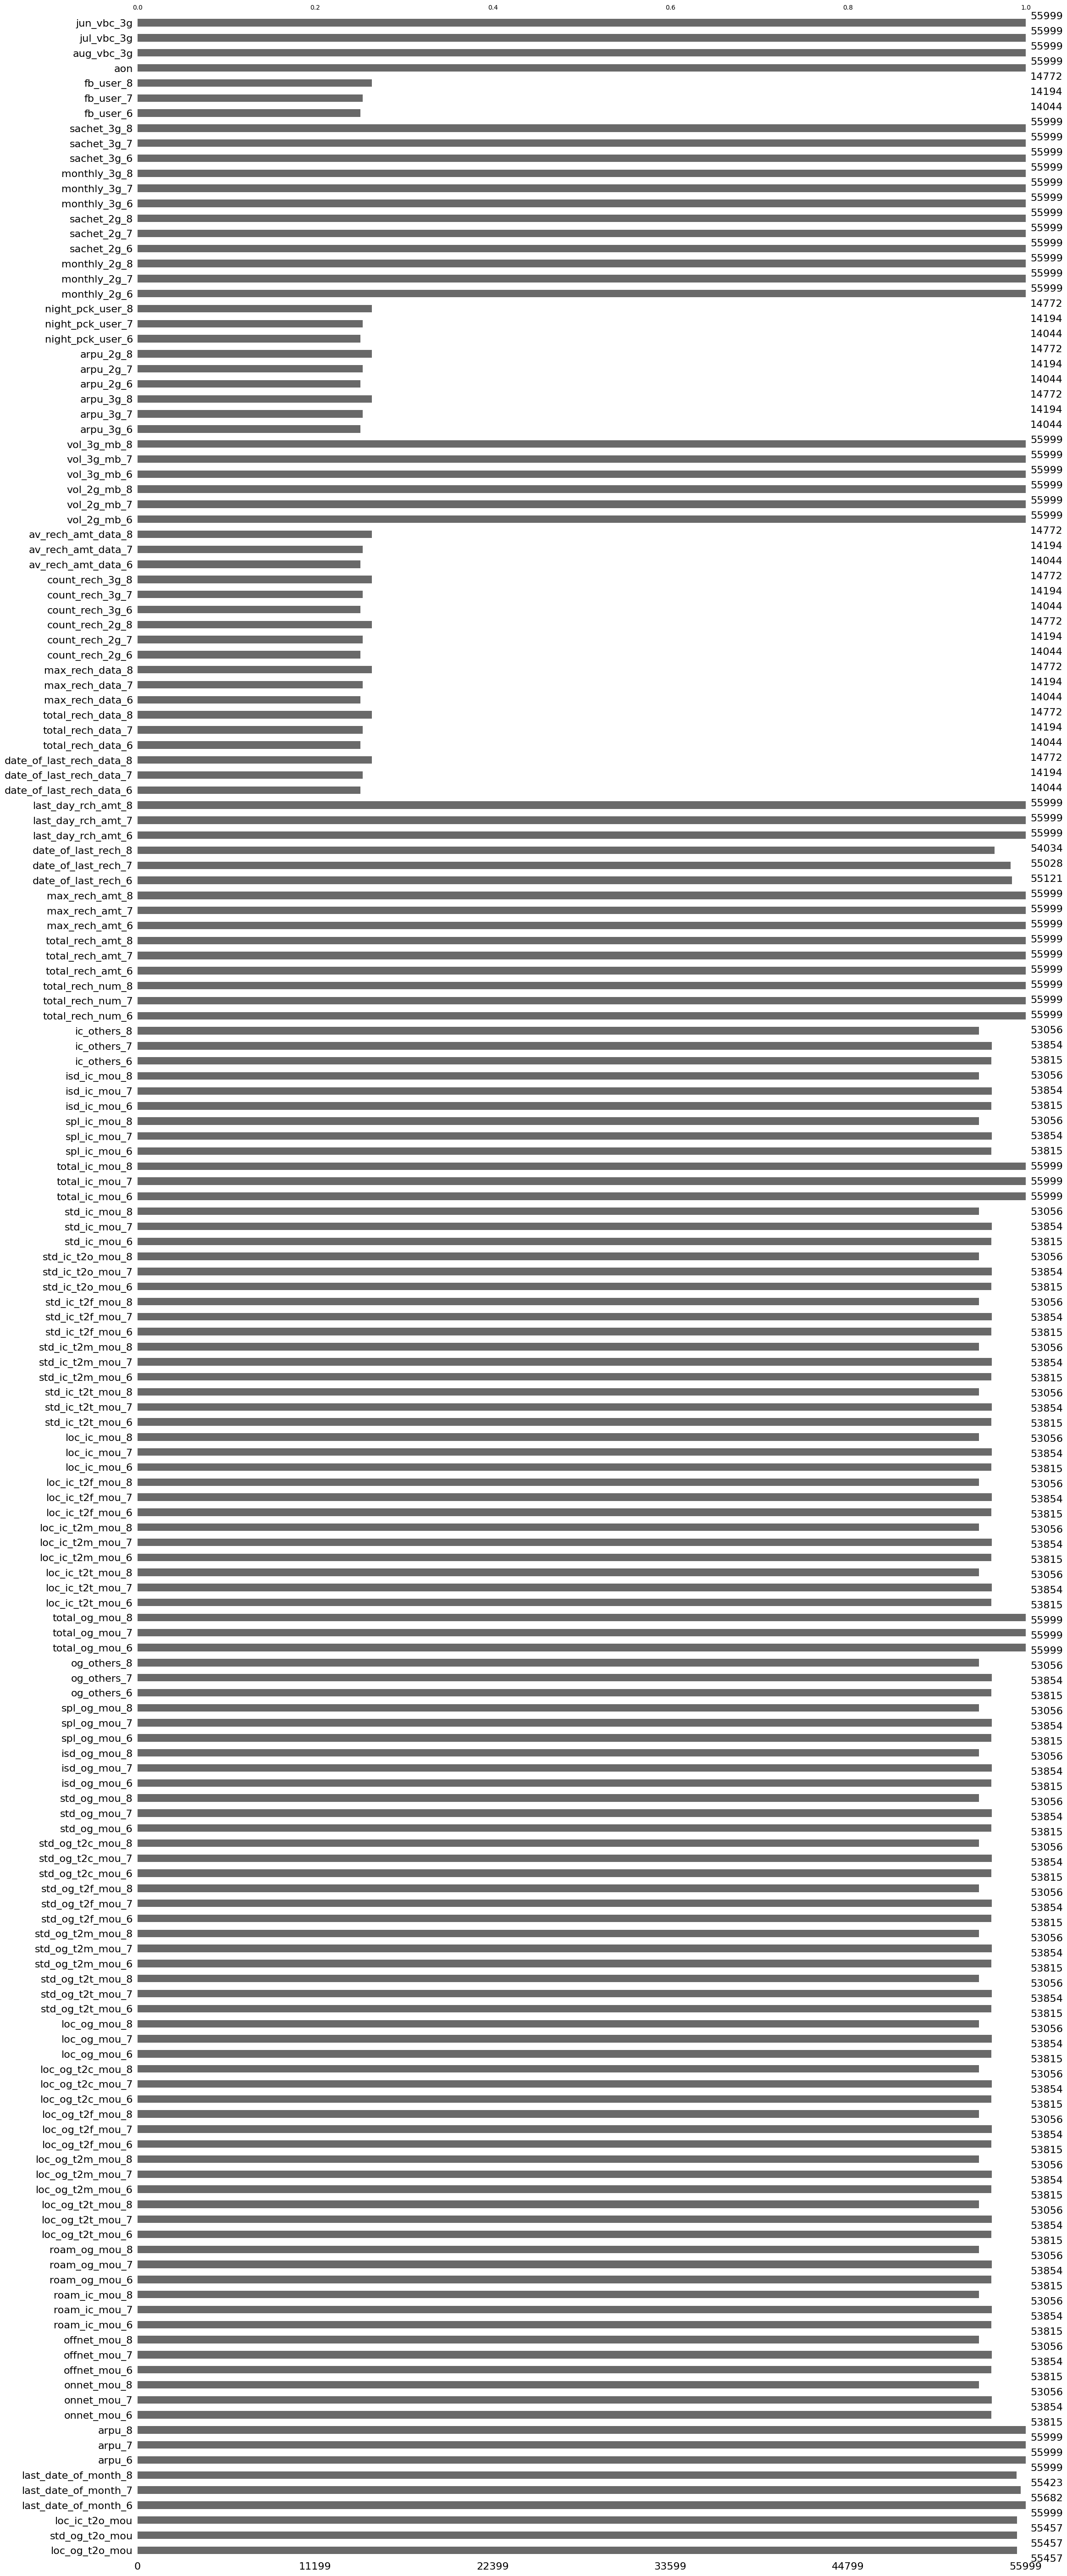

In [13]:
#Visualizing missing data in the dataset
msno.bar(X_train)

<Axes: >

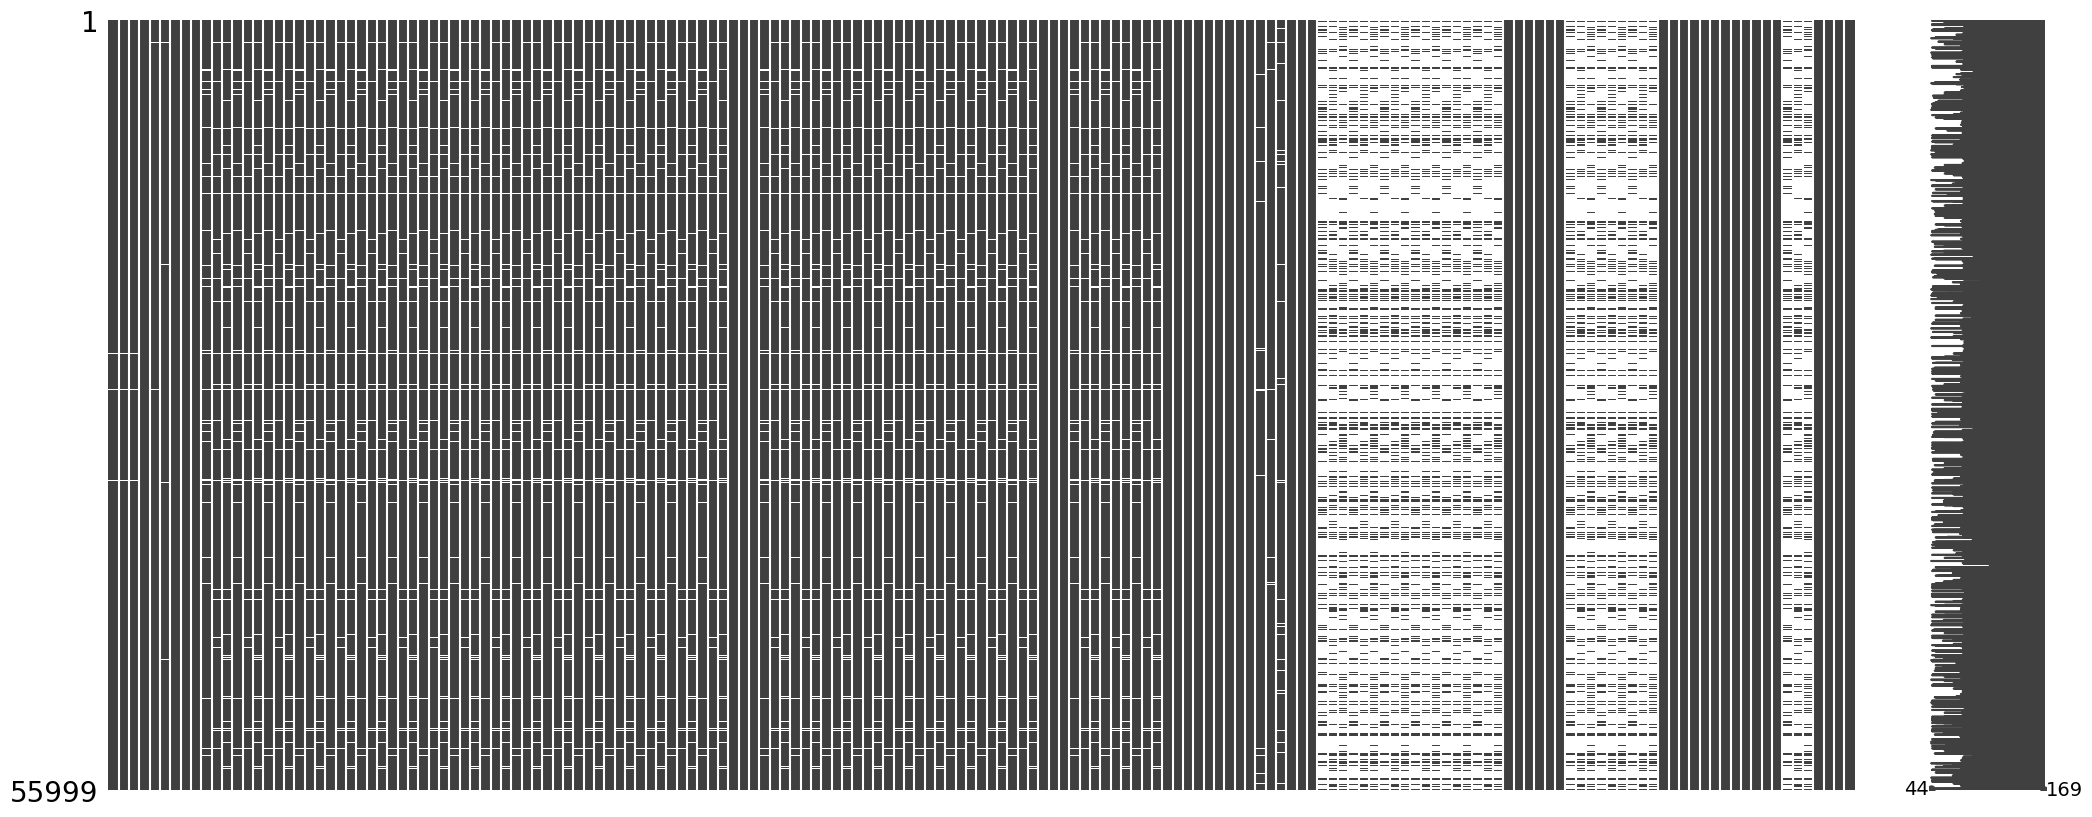

In [14]:
msno.matrix(X_train)

Looks like there are some clusters of missing data

In [15]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

date_of_last_rech_data_6    74.920981
count_rech_3g_6             74.920981
arpu_3g_6                   74.920981
av_rech_amt_data_6          74.920981
fb_user_6                   74.920981
night_pck_user_6            74.920981
arpu_2g_6                   74.920981
count_rech_2g_6             74.920981
max_rech_data_6             74.920981
total_rech_data_6           74.920981
arpu_3g_7                   74.653119
max_rech_data_7             74.653119
total_rech_data_7           74.653119
count_rech_3g_7             74.653119
av_rech_amt_data_7          74.653119
arpu_2g_7                   74.653119
night_pck_user_7            74.653119
fb_user_7                   74.653119
count_rech_2g_7             74.653119
date_of_last_rech_data_7    74.653119
av_rech_amt_data_8          73.620958
total_rech_data_8           73.620958
max_rech_data_8             73.620958
count_rech_3g_8             73.620958
count_rech_2g_8             73.620958
arpu_3g_8                   73.620958
date_of_last

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 30% missing data.

In [16]:
new_vars = missing_data_percent[missing_data_percent.le(30)].index
new_vars

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=139)

In [17]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 139)

Lets check the missing values again

In [18]:
missing_data_percent = 100*X_train_filtered.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

spl_ic_mou_8            5.255451
isd_ic_mou_8            5.255451
std_ic_t2m_mou_8        5.255451
std_ic_t2t_mou_8        5.255451
loc_ic_mou_8            5.255451
loc_ic_t2f_mou_8        5.255451
loc_og_t2t_mou_8        5.255451
loc_og_t2m_mou_8        5.255451
roam_og_mou_8           5.255451
roam_ic_mou_8           5.255451
loc_og_t2c_mou_8        5.255451
loc_og_t2f_mou_8        5.255451
loc_ic_t2m_mou_8        5.255451
std_ic_t2f_mou_8        5.255451
onnet_mou_8             5.255451
offnet_mou_8            5.255451
ic_others_8             5.255451
std_ic_mou_8            5.255451
std_og_t2c_mou_8        5.255451
spl_og_mou_8            5.255451
loc_ic_t2t_mou_8        5.255451
og_others_8             5.255451
std_og_t2m_mou_8        5.255451
std_og_t2f_mou_8        5.255451
std_og_t2t_mou_8        5.255451
loc_og_mou_8            5.255451
isd_og_mou_8            5.255451
std_ic_t2o_mou_8        5.255451
std_og_mou_8            5.255451
loc_ic_mou_6            3.900070
loc_og_t2t

There are multiple ways to deal with missing values. Some of the quickest way is using the following strategy:

- For numerical columns use "Median"
- For catageorical columns use "Mode"

We will try this scheme and build a model, if there are more granular analysis to be made will circle back on it

In [19]:
# Selecting numeric dtype columns

numeric_cols=X_train_filtered.select_dtypes(include=["float64","int64"]).columns
numeric_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=133)

We will use a "SimpleImputer" to impute these columns

In [20]:
imp_num = SimpleImputer(strategy='median') # Using median as a strategy
X_train_filtered[numeric_cols] = imp_num.fit_transform(X_train_filtered[numeric_cols])

In [21]:
# Selecting object type columns which may include dates
obj_cols=X_train_filtered.select_dtypes(include=["object"]).columns
obj_cols

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],
      dtype='object')

In [22]:
imp_obj = SimpleImputer(strategy="most_frequent") # Using Mode for string or date type data
X_train_filtered[obj_cols] = imp_obj.fit_transform(X_train_filtered[obj_cols])

<Axes: >

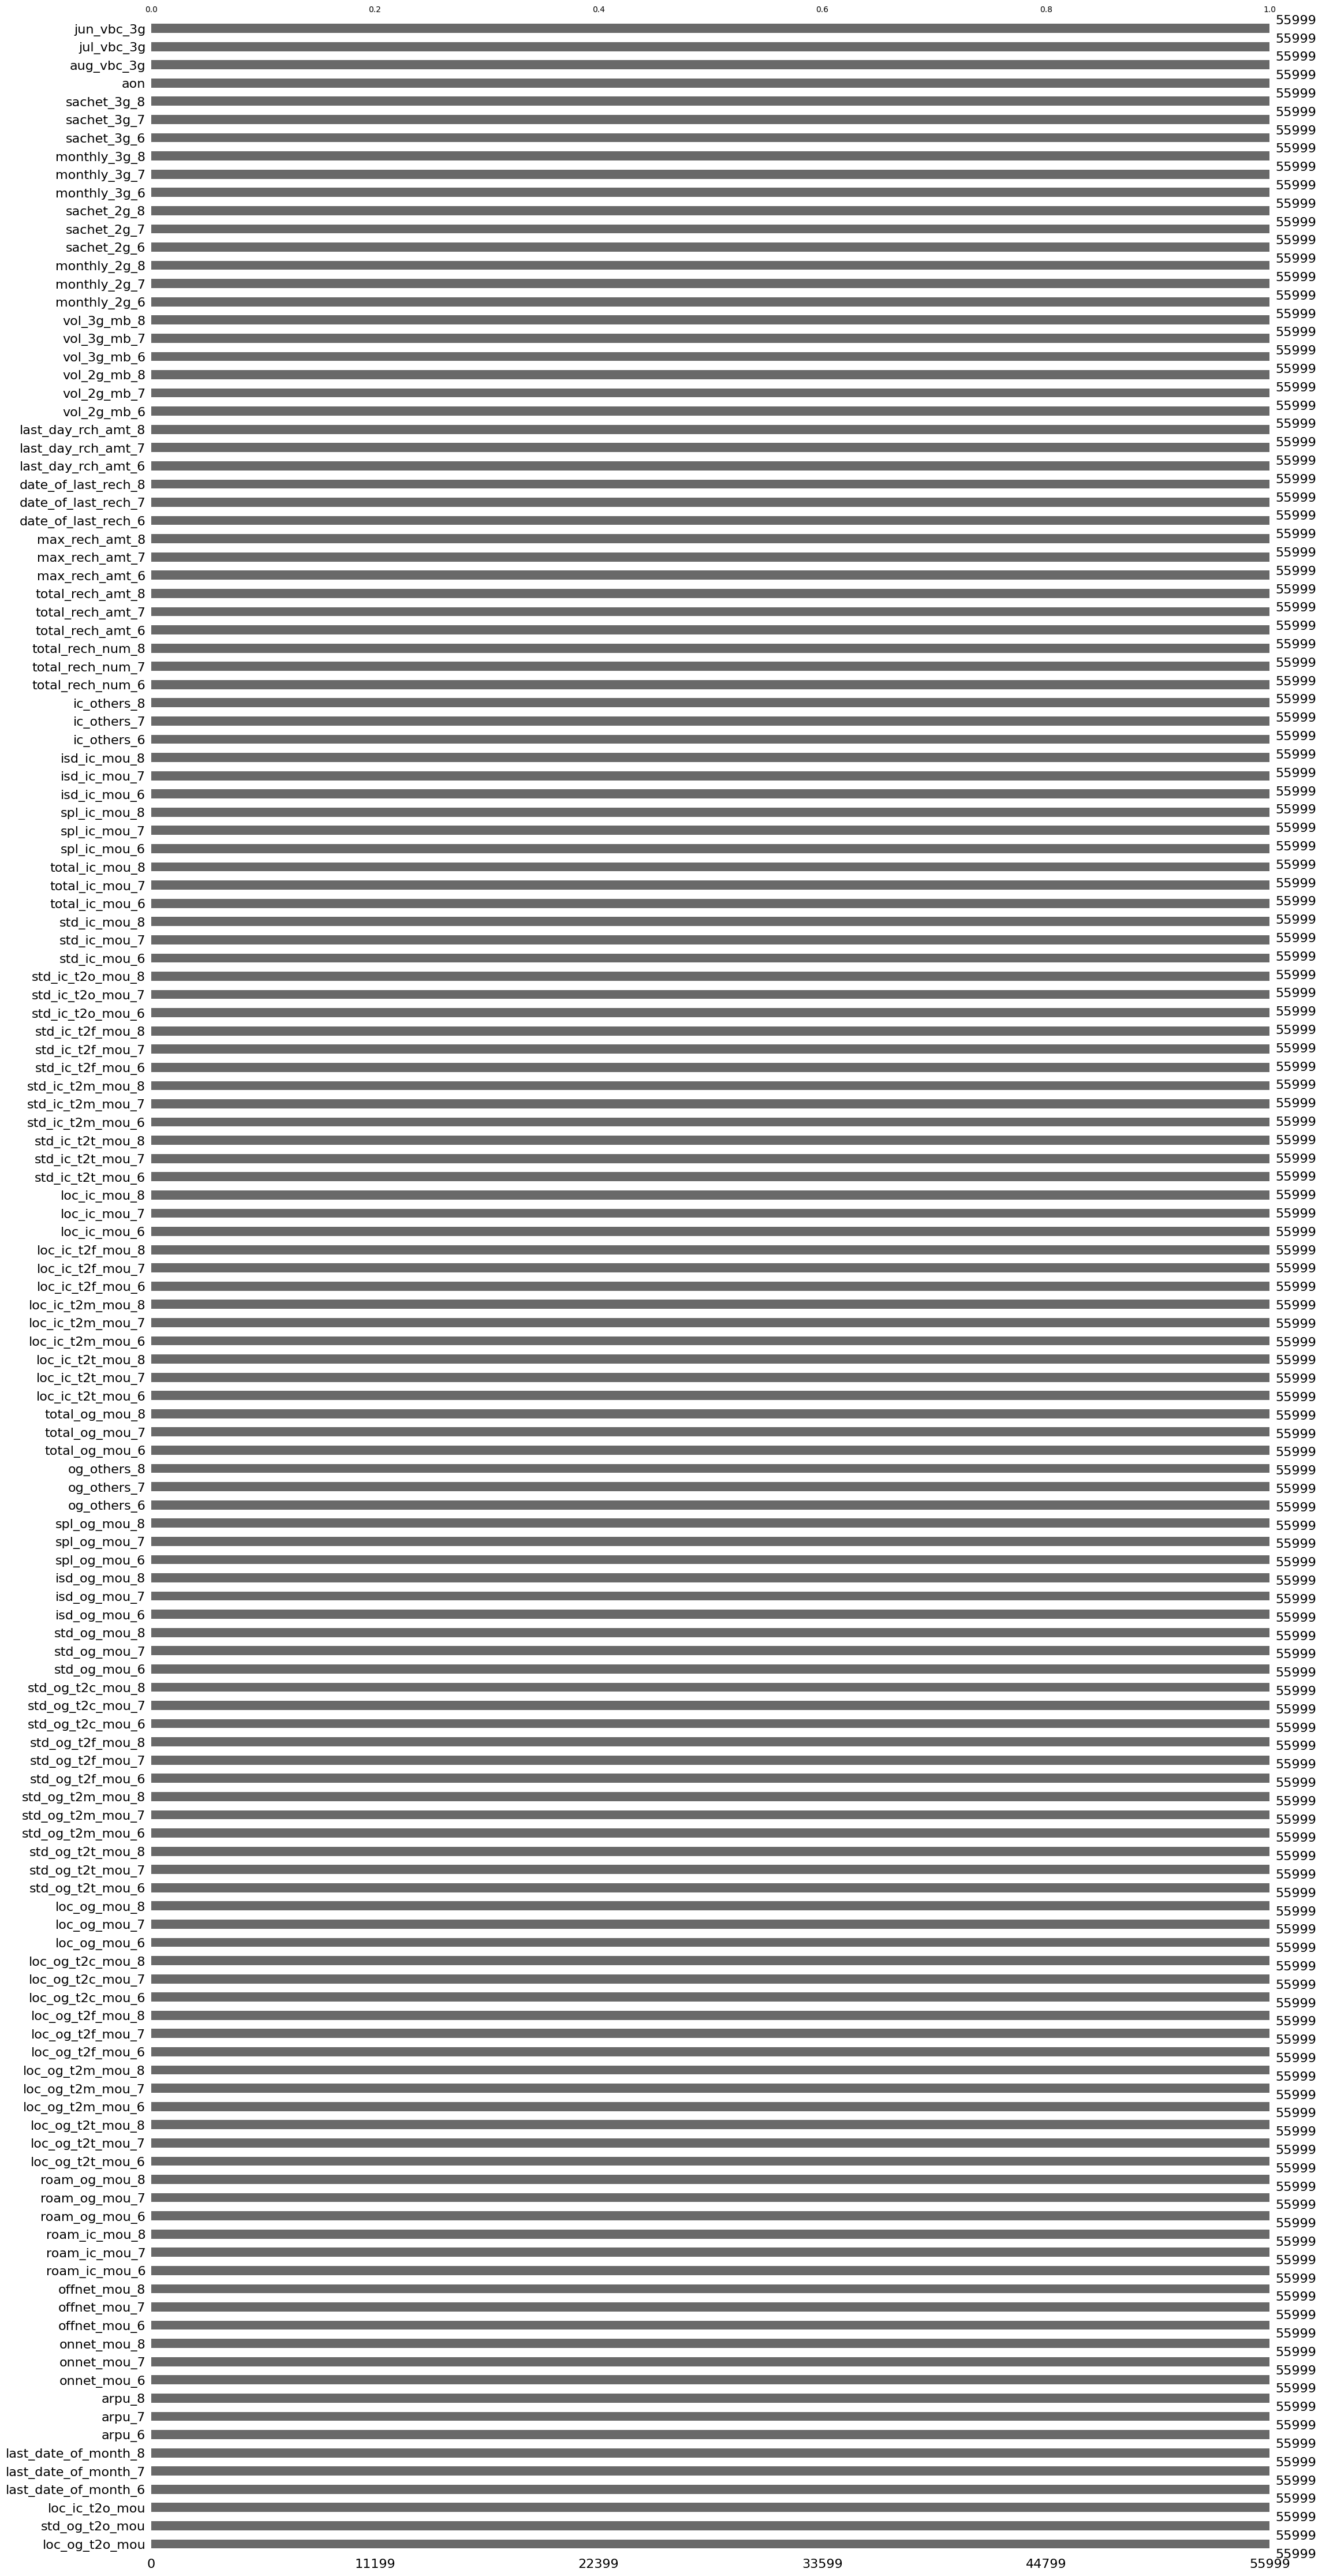

In [23]:
#Lets visualize missing data now
msno.bar(X_train_filtered)

In [24]:
X_train_filtered.isna().mean()

loc_og_t2o_mou          0.0
std_og_t2o_mou          0.0
loc_ic_t2o_mou          0.0
last_date_of_month_6    0.0
last_date_of_month_7    0.0
last_date_of_month_8    0.0
arpu_6                  0.0
arpu_7                  0.0
arpu_8                  0.0
onnet_mou_6             0.0
onnet_mou_7             0.0
onnet_mou_8             0.0
offnet_mou_6            0.0
offnet_mou_7            0.0
offnet_mou_8            0.0
roam_ic_mou_6           0.0
roam_ic_mou_7           0.0
roam_ic_mou_8           0.0
roam_og_mou_6           0.0
roam_og_mou_7           0.0
roam_og_mou_8           0.0
loc_og_t2t_mou_6        0.0
loc_og_t2t_mou_7        0.0
loc_og_t2t_mou_8        0.0
loc_og_t2m_mou_6        0.0
loc_og_t2m_mou_7        0.0
loc_og_t2m_mou_8        0.0
loc_og_t2f_mou_6        0.0
loc_og_t2f_mou_7        0.0
loc_og_t2f_mou_8        0.0
loc_og_t2c_mou_6        0.0
loc_og_t2c_mou_7        0.0
loc_og_t2c_mou_8        0.0
loc_og_mou_6            0.0
loc_og_mou_7            0.0
loc_og_mou_8        

All the missing data has been handled

Lets check for duplicate data

In [25]:
X_train_filtered.duplicated().sum()

0

There are no duplicate data in the train set

# 4. Exploratory Data Analysis & Preprocessing

Lets take a look at the object/string value columns once to see if we can convert date values

In [26]:
X_train_filtered[obj_cols].head()

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
id                                                                     
63606            6/30/2014            7/31/2014            8/31/2014   
46094            6/30/2014            7/31/2014            8/31/2014   
42716            6/30/2014            7/31/2014            8/31/2014   
54324            6/30/2014            7/31/2014            8/31/2014   
53484            6/30/2014            7/31/2014            8/31/2014   

      date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  
id                                                                 
63606           6/12/2014           7/16/2014           8/25/2014  
46094           6/30/2014           7/31/2014           8/26/2014  
42716           6/27/2014           7/31/2014           8/31/2014  
54324           6/27/2014           7/25/2014           8/31/2014  
53484           6/24/2014           7/30/2014           8/30/2014

Since all of them are date values, lets convert them to date dtype

In [27]:
for col in obj_cols:
    X_train_filtered[col] = pd.to_datetime(X_train_filtered[col], format="%m/%d/%Y")

In [28]:
X_train_filtered[obj_cols].dtypes

last_date_of_month_6    datetime64[ns]
last_date_of_month_7    datetime64[ns]
last_date_of_month_8    datetime64[ns]
date_of_last_rech_6     datetime64[ns]
date_of_last_rech_7     datetime64[ns]
date_of_last_rech_8     datetime64[ns]
dtype: object

In [29]:
X_train_filtered[obj_cols].head()

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
id                                                                     
63606           2014-06-30           2014-07-31           2014-08-31   
46094           2014-06-30           2014-07-31           2014-08-31   
42716           2014-06-30           2014-07-31           2014-08-31   
54324           2014-06-30           2014-07-31           2014-08-31   
53484           2014-06-30           2014-07-31           2014-08-31   

      date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  
id                                                                 
63606          2014-06-12          2014-07-16          2014-08-25  
46094          2014-06-30          2014-07-31          2014-08-26  
42716          2014-06-27          2014-07-31          2014-08-31  
54324          2014-06-27          2014-07-25          2014-08-31  
53484          2014-06-24          2014-07-30          2014-08-30

Lets do some EDA on these date columns

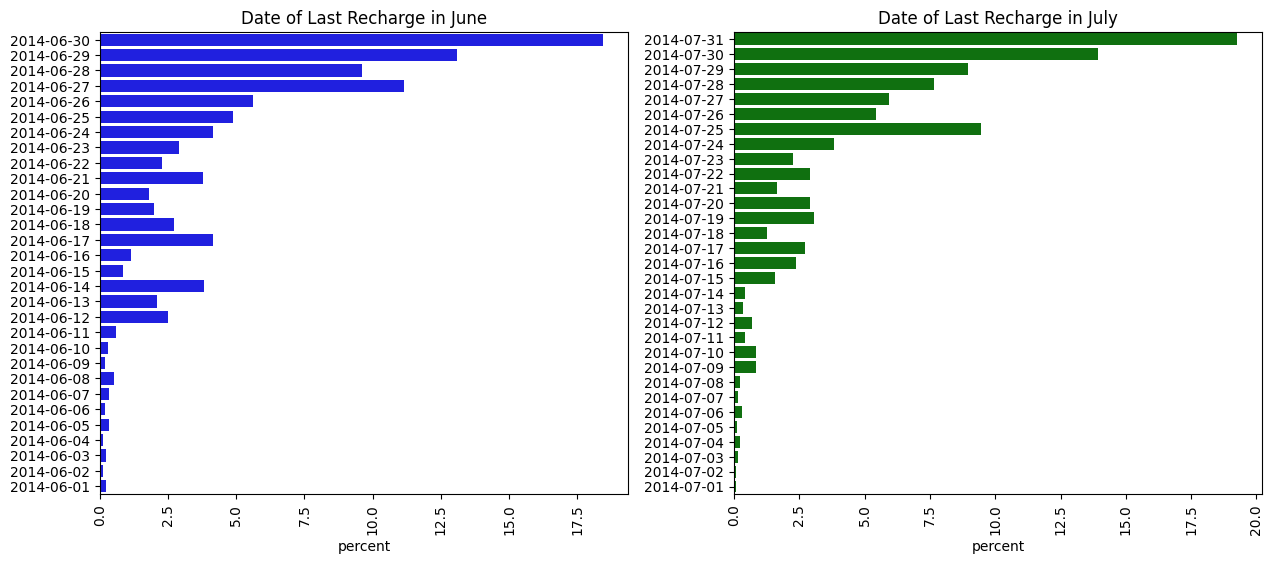

In [30]:
plt.figure(figsize=[15, 6])
plt.subplot(121)
sns.countplot(X_train_filtered["date_of_last_rech_6"].sort_values(ascending=False), stat="percent", color="b").set(ylabel=None)
plt.xticks(rotation=90)
plt.title("Date of Last Recharge in June")
plt.subplot(122)
sns.countplot(X_train_filtered["date_of_last_rech_7"].sort_values(ascending=False), stat="percent", color="g").set(ylabel=None)
plt.xticks(rotation=90)
plt.title("Date of Last Recharge in July")
plt.show()

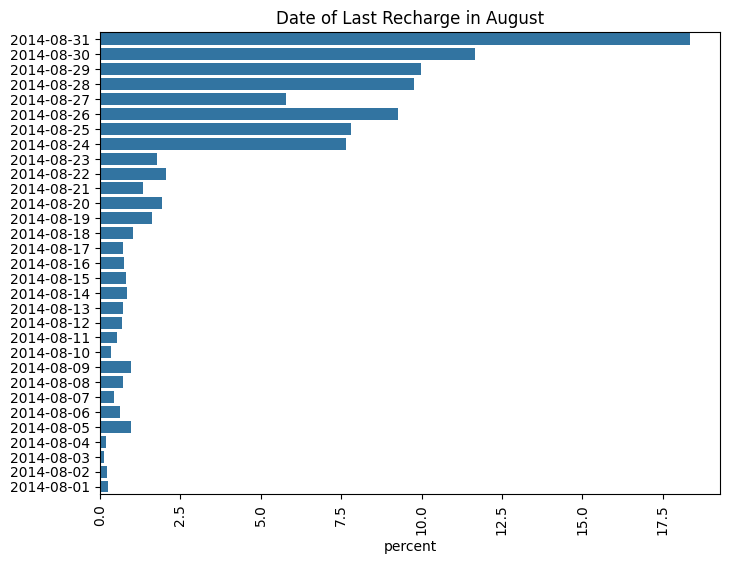

In [31]:
plt.figure(figsize=[8, 6])
sns.countplot(X_train_filtered["date_of_last_rech_8"].sort_values(ascending=False), stat="percent").set(ylabel=None)
plt.xticks(rotation=90)
plt.title("Date of Last Recharge in August")
plt.show()

The trend shows that most of the recharges are happening towards the end of the month

Lets process the numerical columns in terms of outliers and univariate/bivariate/multivariate analysis

In [32]:
# lets check the number of numeric columns in the dataframe
X_train_filtered[numeric_cols].shape[1]

133

In [33]:
# Since the number of columns are pretty high, doing nay univariate analysis of all these columns would be impossible. Lets use the describe function to analyze
X_train_filtered[numeric_cols].describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou        arpu_6  \
count         55999.0         55999.0         55999.0  55999.000000   
mean              0.0             0.0             0.0    283.444749   
std               0.0             0.0             0.0    338.914269   
min               0.0             0.0             0.0  -2258.709000   
25%               0.0             0.0             0.0     93.739000   
50%               0.0             0.0             0.0    198.088000   
75%               0.0             0.0             0.0    371.580000   
90%               0.0             0.0             0.0    619.893400   
95%               0.0             0.0             0.0    833.173300   
99%               0.0             0.0             0.0   1397.432880   
max               0.0             0.0             0.0  27731.088000   

             arpu_7        arpu_8   onnet_mou_6   onnet_mou_7   onnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     278.700407    279.283592    129.546064    130.185744    128.178237   
std      352.801657    359.799417    296.594731    306.217001    307.363605   
min    -1289.715000   -945.808000      0.000000      0.000000      0.000000   
25%       86.299000     84.002500      8.110000      7.340000      7.440000   
50%      192.349000    192.380000     34.380000     32.540000     32.280000   
75%      366.182000    370.499500    113.300000    109.800000    106.630000   
90%      616.513600    616.044400    330.480000    334.060000    327.830000   
95%      823.858400    828.045400    602.106000    605.962000    597.318000   
99%     1418.732160   1447.898960   1424.024000   1450.211400   1442.495800   
max    35145.834000  33543.624000   7376.710000   8157.780000  10752.560000   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count  55999.000000  55999.000000  55999.000000   55999.000000   55999.000000   
mean     194.931846    193.438267    191.345593       9.314684       6.692571   
std      308.618926    313.735077    311.886565      55.127420      53.796055   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       36.820000     34.140000     34.380000       0.000000       0.000000   
50%       96.680000     92.360000     92.130000       0.000000       0.000000   
75%      224.585000    220.260000    217.090000       0.000000       0.000000   
90%      470.012000    470.946000    469.514000      11.090000       4.530000   
95%      719.062000    731.862000    716.490000      38.683000      21.333000   
99%     1527.104000   1519.570400   1490.965400     212.231000     149.040000   
max     5905.140000   6597.430000   7857.780000    2850.980000    4155.830000   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        6.617283      13.754298       9.509253       9.233415   
std        52.193957      74.121455      58.808458      64.674005   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         4.330000      20.980000       8.780000       7.510000   
95%        21.810000      65.142000      39.931000      37.792000   
99%       149.780000     286.811000     216.560600     204.214000   
max      4169.810000    3775.110000    2812.040000    5337.040000   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          46.040539         45.260316         44.634980         91.609428   
std          152.560466        154.824308        156.047876        161.076057   
min            0.000000          0.000000          0.000000          0.000000  

From the above table it is pretty evident that there are lots of outliers in the data and next step we will remove these outliers

### 4.1 Handling outliers


These outliers can be capped with k-sigma method.


In [34]:
# Define a function to remove outliers

def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [35]:
X_train_filtered[numeric_cols] = X_train_filtered[numeric_cols].apply(cap_outliers, axis=0)

In [36]:
# Lets check the dataframe again to check the summary statistics
X_train_filtered[numeric_cols].describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou        arpu_6  \
count         55999.0         55999.0         55999.0  55999.000000   
mean              0.0             0.0             0.0    276.060290   
std               0.0             0.0             0.0    263.963523   
min               0.0             0.0             0.0   -733.298058   
25%               0.0             0.0             0.0     93.739000   
50%               0.0             0.0             0.0    198.088000   
75%               0.0             0.0             0.0    371.580000   
90%               0.0             0.0             0.0    619.893400   
95%               0.0             0.0             0.0    833.173300   
99%               0.0             0.0             0.0   1300.187556   
max               0.0             0.0             0.0   1300.187556   

             arpu_7        arpu_8   onnet_mou_6   onnet_mou_7   onnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     271.343617    271.628779    116.401501    116.644979    114.717989   
std      266.587634    270.103096    208.728479    213.521233    211.449648   
min     -779.704563   -800.114659      0.000000      0.000000      0.000000   
25%       86.299000     84.002500      8.110000      7.340000      7.440000   
50%      192.349000    192.380000     34.380000     32.540000     32.280000   
75%      366.182000    370.499500    113.300000    109.800000    106.630000   
90%      616.513600    616.044400    330.480000    334.060000    327.830000   
95%      823.858400    828.045400    602.106000    605.962000    597.318000   
99%     1337.105377   1358.681843   1019.330259   1048.836747   1050.269052   
max     1337.105377   1358.681843   1019.330259   1048.836747   1050.269052   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
count  55999.000000  55999.000000  55999.000000   55999.000000   55999.000000   
mean     182.510955    180.990528    179.227848       6.734179       4.592410   
std      235.773638    239.233811    236.507589      25.909100      20.922397   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       36.820000     34.140000     34.380000       0.000000       0.000000   
50%       96.680000     92.360000     92.130000       0.000000       0.000000   
75%      224.585000    220.260000    217.090000       0.000000       0.000000   
90%      470.012000    470.946000    469.514000      11.090000       4.530000   
95%      719.062000    731.862000    716.490000      38.683000      21.333000   
99%     1120.788625   1134.643497   1127.005288     174.696946     149.040000   
max     1120.788625   1134.643497   1127.005288     174.696946     168.080738   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        4.514770      10.325085       6.753925       6.643651   
std        20.518995      37.052978      27.284175      27.899418   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         4.330000      20.980000       8.780000       7.510000   
95%        21.810000      65.142000      39.931000      37.792000   
99%       149.780000     236.118664     185.934627     203.255431   
max       163.199155     236.118664     185.934627     203.255431   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          39.500824         38.718373         38.442467         85.391341   
std           78.172971         77.355801         77.228684        118.847770   
min            0.000000          0.000000          0.000000          0.000000  

Lets drop columns which have zero values

In [37]:
exclude_cols = ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
numeric_cols = numeric_cols.difference(exclude_cols)
numeric_cols

Index(['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'ic_others_6',
       'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7',
       ...
       'total_rech_amt_8', 'total_rech_num_6', 'total_rech_num_7',
       'total_rech_num_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8',
       'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8'],
      dtype='object', length=124)

In [38]:
# Also drop these columns from X_train

X_train_filtered.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], axis=1, inplace=True)

Lets also plot the correlations for each feature for bivariate analysis.

In [39]:
data_eda = pd.concat([X_train_filtered[numeric_cols], y_train], axis=1)
data_eda.head()

aon   arpu_6   arpu_7   arpu_8  aug_vbc_3g  ic_others_6  \
id                                                                  
63606   351.0  109.004  352.270  181.747         0.0         0.00   
46094   324.0  461.752  298.124  465.264         0.0         0.34   
42716  2286.0  678.630  507.652  335.927         0.0         0.00   
54324  3651.0  131.200  118.830  101.846         0.0         2.49   
53484  1167.0  397.645  375.069  550.051         0.0         1.66   

       ic_others_7  ic_others_8  isd_ic_mou_6  isd_ic_mou_7  isd_ic_mou_8  \
id                                                                          
63606         0.00         0.00          1.36          0.00      0.110000   
46094         0.55         0.00          0.00          0.00      0.000000   
42716         0.00         0.00          0.00          0.00      0.080000   
54324         5.03         0.31         20.88        141.48    185.120616   
53484         2.18         0.06          0.00          0.00      0.000000   

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  jul_vbc_3g  jun_vbc_3g  \
id                                                                        
63606           0.0          0.00          0.00         0.0         0.0   
46094           0.0          0.00          0.00         0.0         0.0   
42716           0.0          0.00          0.00         0.0         0.0   
54324           0.0          0.55          1.73         0.0         0.0   
53484           0.0          0.00          0.53         0.0         0.0   

       last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
id                                                                  
63606          356.133288                 0.0                 0.0   
46094           30.000000                25.0                30.0   
42716          110.000000                25.0               130.0   
54324            0.000000                 0.0               130.0   
53484          110.000000                50.0                20.0   

       loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  loc_ic_t2f_mou_6  \
id                                                                  
63606        128.41        169.76        183.23              4.69   
46094         40.08         22.44         26.54              0.00   
42716        223.63        281.36        231.44              0.00   
54324        153.48        115.41        155.43              1.40   
53484         50.14         26.64         80.59              0.26   

       loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  \
id                                                                              
63606              1.54              7.79            113.74            157.44   
46094              0.00              0.41             34.26             21.16   
42716              0.00              0.23            105.88            187.36   
54324              0.23              0.98             82.98             81.06   
53484              0.13              2.31             33.64             15.73   

       loc_ic_t2m_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
id                                                                              
63606            170.98              9.96             10.76              4.44   
46094             21.88              5.81              1.28              4.24   
42716            131.71            117.74             93.99             99.49   
54324            119.63             69.09             34.11             34.81   
53484             29.31             16.23             10.78             48.96   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_t2c_mou_6  \
id                                                                  
63606        118.46         72.13         50.86              0.00   
46094        247.94         63.19         14.54              0.00   
42716        131.44        208.21        181.38              0.00   
54324      

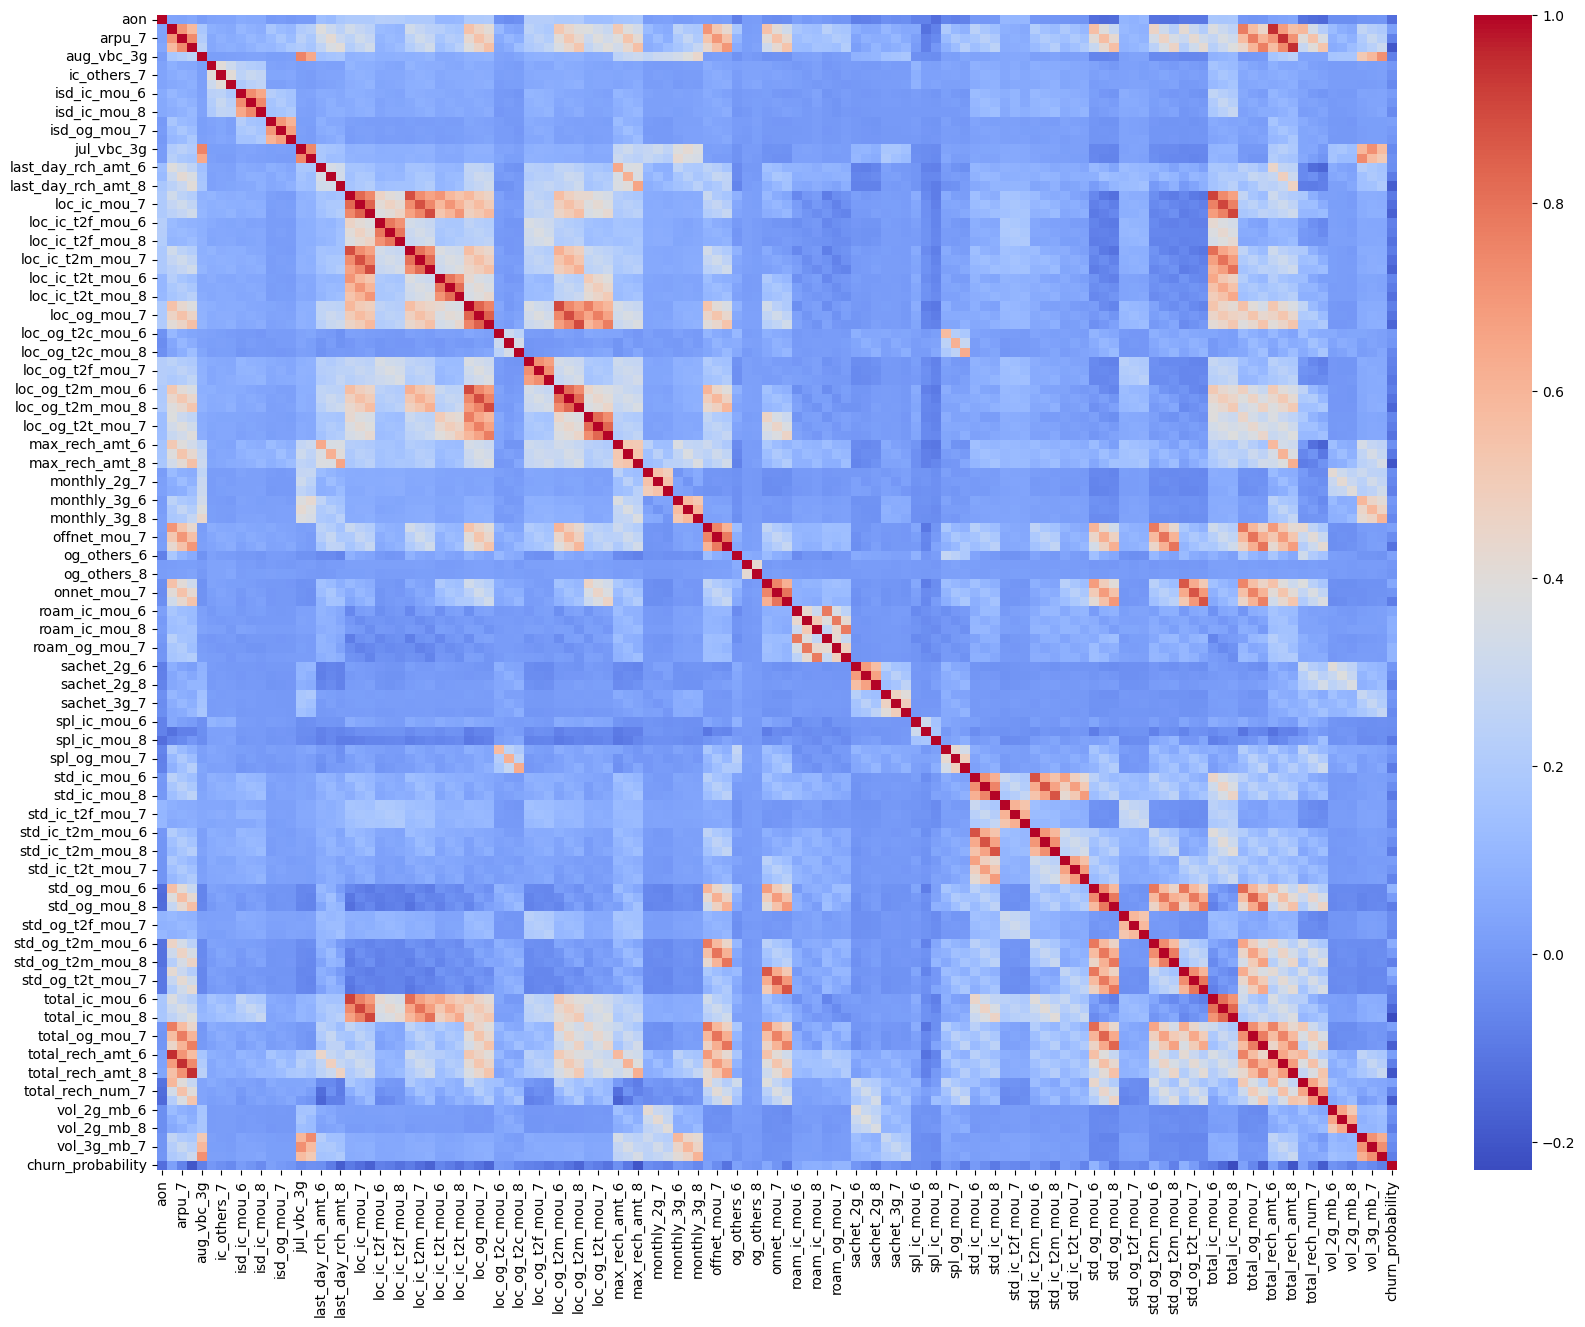

In [40]:
# Lets check the correlations of the numeric variables with each other and with "churn_probability"
plt.figure(figsize=(20, 15))
sns.heatmap(data_eda.corr(), cmap="coolwarm")
plt.show()

There seems to be light correlation, Lets do a deep dive

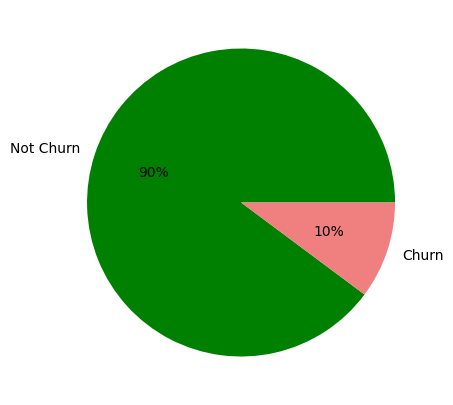

In [41]:
# Plot churn_probability
plt.figure(figsize= (6,5)) 
labels = ['Not Churn','Churn']
colors = ['green', 'lightcoral']
plt.pie(data_eda.churn_probability.value_counts(), labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

The data is imbalanced so we may have to apply class imbalance techniques prior to training models

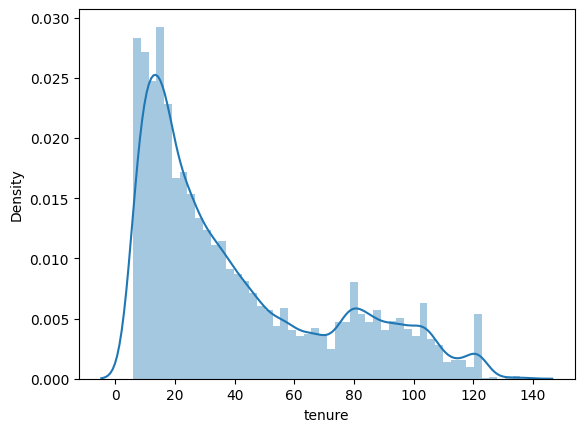

In [42]:
# Lets check churn probability w.r.t tenure or age on network varaible
data_eda["tenure"] = data_eda["aon"]/30
sns.distplot(data_eda["tenure"], bins=50)
plt.show()

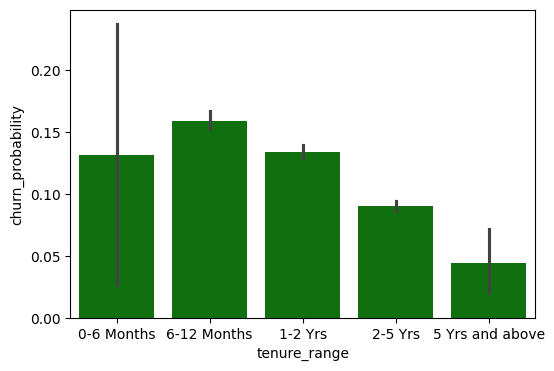

In [43]:
tenure_range = [0, 6, 12, 24, 60, 61]
tenure_label = ['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data_eda['tenure_range'] = pd.cut(data_eda['tenure'], tenure_range, labels=tenure_label)
plt.figure(figsize=[6,4])
sns.barplot(x='tenure_range', y='churn_probability', data=data_eda, color='g')
plt.show()

Its evident from above plot that maximum churn happens during first 6 months and as time goes by, less churn happens.

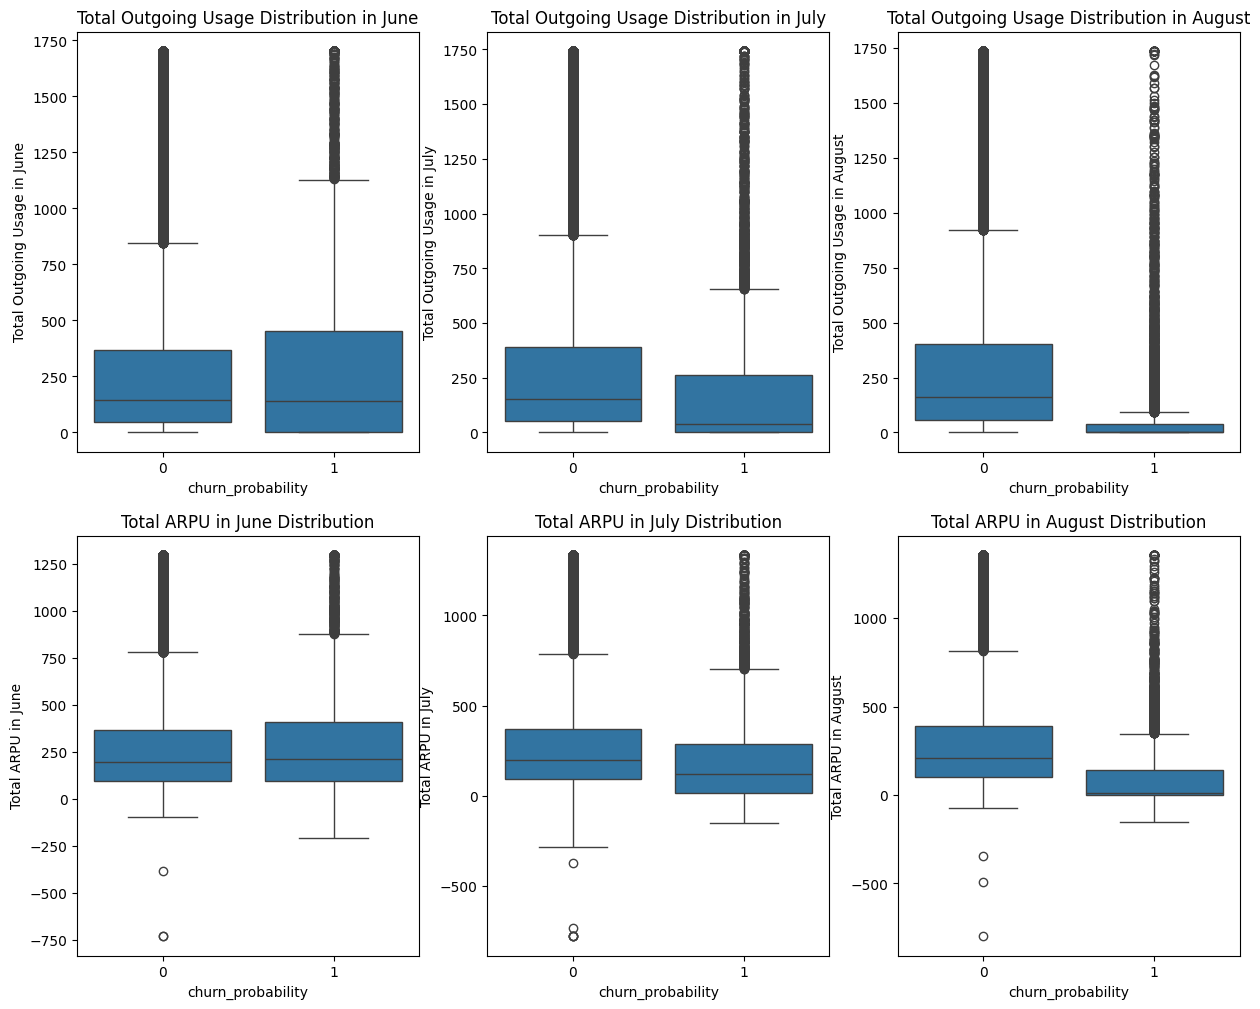

In [44]:
plt.figure(figsize=[15, 12])
plt.subplot(231)
sns.boxplot(x="churn_probability", y='total_og_mou_6', data=data_eda)
plt.ylabel('Total Outgoing Usage in June')
plt.title("Total Outgoing Usage Distribution in June")

plt.subplot(232)
sns.boxplot(x="churn_probability", y='total_og_mou_7', data=data_eda)
plt.ylabel('Total Outgoing Usage in July')
plt.title("Total Outgoing Usage Distribution in July")

plt.subplot(233)
sns.boxplot(x="churn_probability", y='total_og_mou_8', data=data_eda)
plt.ylabel('Total Outgoing Usage in August')
plt.title("Total Outgoing Usage Distribution in August")

plt.subplot(234)
sns.boxplot(x="churn_probability", y='arpu_6', data=data_eda)
plt.ylabel('Total ARPU in June')
plt.title("Total ARPU in June Distribution")

plt.subplot(235)
sns.boxplot(x="churn_probability", y='arpu_7', data=data_eda)
plt.ylabel('Total ARPU in July')
plt.title("Total ARPU in July Distribution")

plt.subplot(236)
sns.boxplot(x="churn_probability", y='arpu_8', data=data_eda)
plt.ylabel('Total ARPU in August')
plt.title("Total ARPU in August Distribution")

plt.show()

**Analysis**:

- Customers with higher outgoing calls in the sixth month with reduction of calls/usage in eighth month have a high chance of churning
- As the ARPU of the customer decreases from sixth to eighth month, the probability of churn increases

# 5. Feature Engineering and Selection

In this section we will try to add some derived metrics to increase the chances of a better model for example

- "Average gain of 3g and 2g data volume from month 6 to 8" - (growth or decline of 3g usage month over month?)

- "Standard deviation of the recharges from month six to month eight" - (too much variability in charges?)

In [45]:
# Create new features like gain in 3G and 2G data volume from month six to eight
X_train_filtered["gain_3g_vol"] = X_train_filtered["vol_3g_mb_8"]- X_train_filtered["vol_3g_mb_6"]
X_train_filtered["gain_2g_vol"] = X_train_filtered["vol_2g_mb_8"]- X_train_filtered["vol_2g_mb_6"]
X_train_filtered["gain_3g_vol"].head()

id
63606      0.000000
46094      0.000000
42716   -958.236756
54324      0.000000
53484      0.000000
Name: gain_3g_vol, dtype: float64

In [46]:
X_train_filtered["gain_2g_vol"].head()

id
63606    0.000000
46094   -8.826091
42716    0.000000
54324    0.000000
53484    0.000000
Name: gain_2g_vol, dtype: float64

In [47]:
# Create new variable for increase or decrease of recharge variablility from month six to eight
X_train_filtered["rech_variability_increase"] = X_train_filtered["total_rech_amt_8"].std() - X_train_filtered["total_rech_amt_6"].std()
X_train_filtered["rech_variability_increase"].head()

id
63606    7.647428
46094    7.647428
42716    7.647428
54324    7.647428
53484    7.647428
Name: rech_variability_increase, dtype: float64

Finalize X_train variables prior to Feature scaling and modelling

Lets drop the date variables prior to scaling and model training

In [48]:
X_train_final = X_train_filtered.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1)

In [49]:
X_train_final.shape

(55999, 127)

In [50]:
X_train_final.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                        
63606  109.004  352.270  181.747        11.31         3.19         0.00   
46094  461.752  298.124  465.264       113.98        82.64        27.84   
42716  678.630  507.652  335.927        50.53        68.96        59.53   
54324  131.200  118.830  101.846        37.49         6.24        16.78   
53484  397.645  375.069  550.051       418.73       315.44       411.58   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                              
63606        154.28         68.93         51.48            0.0            0.0   
46094        344.14        146.69         22.13            0.0            0.0   
42716         81.39        150.56        121.84            0.0            0.0   
54324         96.06         84.18         73.39            0.0            0.0   
53484         65.09        102.99        176.63            0.0            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
63606            0.0            0.0            0.0            0.0   
46094            0.0            0.0            0.0            0.0   
42716            0.0            0.0            0.0            0.0   
54324            0.0            0.0            0.0            0.0   
53484            0.0            0.0            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
id                                                                              
63606              6.56              3.19              0.00             82.93   
46094             13.93              9.74              4.88            234.01   
42716             50.53             68.96             59.53             80.91   
54324             37.49              6.24             16.78             90.24   
53484             12.44              9.76             24.81             28.11   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
id                                                                              
63606             66.64             50.28             28.96              2.28   
46094             53.44              9.66              0.00              0.00   
42716            139.24            121.84              0.00              0.00   
54324             73.79             64.04              5.81             10.38   
53484             25.93             22.66              0.00              0.00   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                              
63606              0.58              0.00               0.0              0.00   
46094              0.00              0.00               0.0              0.00   
42716              0.00              0.00               0.0              0.00   
54324              0.00              0.00               0.0              1.90   
53484              0.00              0.25               0.0              0.45   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
id                                                                  
63606        118.46         72.13         50.86              4.75   
46094        247.94         63.19         14.54            100.04   
42716        131.44        208.21        181.38              0.00   
54324        133.56         90.43         80.83              0.00   
53484         40.56         35.69         47.48            406.28   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
id                                                                              
63606              0.00              0.00             42.38              0.00   

In [51]:
final_columns = X_train_final.columns
final_columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'gain_3g_vol', 'gain_2g_vol',
       'rech_variability_increase'],
      dtype='object', length=127)

## 5.1 Feature scaling

We sill use a Standard Scaler to scale the numerical features

In [52]:
# Scale the features. All features now in X_train are numerical
scale = StandardScaler()
X_train_final_scaled = scale.fit_transform(X_train_final)

In [53]:
pd.DataFrame(X_train_final_scaled, columns=final_columns).head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0 -0.632882  0.303567 -0.332771    -0.503489    -0.531357    -0.542536   
1  0.703481  0.100457  0.716900    -0.011601    -0.159259    -0.410872   
2  1.525110  0.886427  0.238053    -0.315587    -0.223329    -0.261001   
3 -0.548794 -0.572101 -0.628591    -0.378062    -0.517073    -0.463178   
4  0.460616  0.389089  1.030809     1.448442     0.931040     1.403950   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0     -0.119739     -0.468418     -0.540148      -0.259918      -0.219499   
1      0.685532     -0.143378     -0.664246      -0.259918      -0.219499   
2     -0.428894     -0.127201     -0.242649      -0.259918      -0.219499   
3     -0.366673     -0.404673     -0.447507      -0.259918      -0.219499   
4     -0.498029     -0.326046     -0.010984      -0.259918      -0.219499   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0      -0.220031       -0.27866      -0.247542      -0.238131   
1      -0.220031       -0.27866      -0.247542      -0.238131   
2      -0.220031       -0.27866      -0.247542      -0.238131   
3      -0.220031       -0.27866      -0.247542      -0.238131   
4      -0.220031       -0.27866      -0.247542      -0.238131   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0         -0.421388         -0.459289         -0.497779         -0.020710   
1         -0.327109         -0.374615         -0.434589          1.250507   
2          0.141088          0.390945          0.273056         -0.037707   
3         -0.025723         -0.419861         -0.280500          0.040798   
4         -0.346169         -0.374356         -0.176522         -0.481977   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0         -0.145868         -0.287585          3.325615         -0.105205   
1         -0.260843         -0.643341         -0.395500         -0.395691   
2          0.486495          0.339148         -0.395500         -0.395691   
3         -0.083590         -0.167073          0.351036          0.926789   
4         -0.500462         -0.529485         -0.395500         -0.395691   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0         -0.315199         -0.302030         -0.297268         -0.317276   
1         -0.392120         -0.302030         -0.297268         -0.317276   
2         -0.392120         -0.302030         -0.297268         -0.317276   
3         -0.392120         -0.302030         -0.297268          0.232141   
4         -0.392120         -0.216226         -0.297268         -0.187151   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0     -0.073891     -0.321102     -0.439065         -0.361868   
1      0.637544     -0.371417     -0.644393          0.207716   
2     -0.002572      0.444766      0.298804         -0.390260   
3      0.009077     -0.218109     -0.269636         -0.390260   
4     -0.501917     -0.526190     -0.458173          2.038228   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0         -0.390819         -0.386177         -0.181276         -0.435459   
1          0.028148         -0.252874          0.229155          0.102585   
2         -0.390819         -0.386177         -0.438015         -0.370194   
3         -0.390819         -0.386177         -0.438015         -0.435459   
4          1.366210          1.859316         -0.215503          0.008237   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0         -0.426321         -0.226499         -0.220733          -0.21888   
1         -0.415536         -0.226499         -0.220733          -0.21888   
2         -0.429877         -0.084574         -0.220733          -0.21888   
3         -0.429877         -0.226499         -0.220733          -0.21888   
4          0.461924         -0.226499         -0.220733          -0.21888   



We need to handle Class imbalance using one of the industry methdologies SMOTE - Synthetic Minority Oversampling Technique

In [57]:
oversample = SMOTE(random_state=100, sampling_strategy=0.5)

In [58]:
X_train_model1, y_train_model1 = oversample.fit_resample(X_train_final_scaled, y_train)

In [59]:
from collections import Counter
counter = Counter(y_train_model1)
counter

Counter({0: 50291, 1: 25145})

So for "Churn" classes we have increased the samples to be about 50% of "Non-Churn" cases

# 6. Model building and Evaluation

Before we start model building, in order to quickly reach an efficient model building and evaluation we will use dimensionality reduction technique like PCA (Principal Component Analysis)

Our train data has around 127 columns after data manipulation and feature engineering. That is a lot of columns, so we will use PCA to highlight optimum number of components for model building

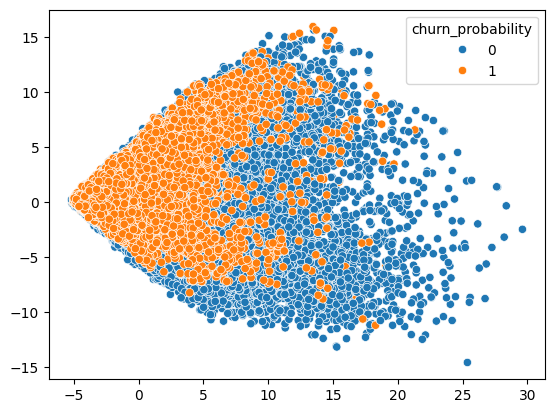

In [60]:
# Initialize PCA
pca = PCA()
pca_components = pca.fit_transform(X_train_model1)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_model1)
plt.show()

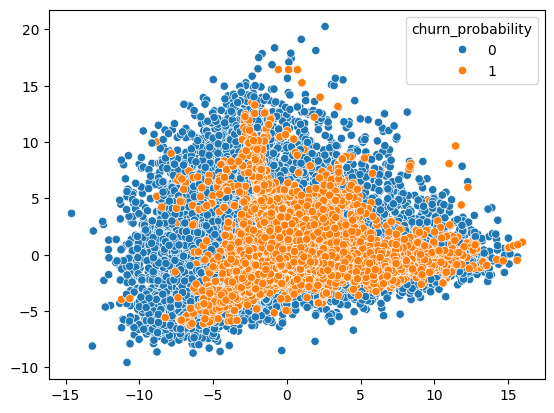

In [61]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train_model1)
plt.show()

Since we have oversampled the "Churn" classes, we see a good representation of the same in the visualization in the first 3 PCA components

Lets see how many PCA components are able to explain more than 90% of variance in the model


In [64]:
pca.components_

array([[ 1.68216365e-01,  1.87512396e-01,  1.73565752e-01, ...,
         1.08686564e-02,  4.40847248e-03, -0.00000000e+00],
       [ 7.00296451e-02,  7.13761812e-02,  3.61431294e-02, ...,
        -1.31977375e-03,  5.85561297e-03,  0.00000000e+00],
       [ 5.94302589e-02,  9.41551658e-02,  1.01000200e-01, ...,
         1.18893606e-02, -2.08514063e-02, -0.00000000e+00],
       ...,
       [ 2.55047111e-15,  4.65241613e-15,  7.15139703e-15, ...,
        -4.91208486e-01,  2.00348181e-01, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-0.00000000e+00,  2.34069982e-15, -2.18865977e-15, ...,
         1.84324205e-01,  5.33911033e-01, -0.00000000e+00]])

In [66]:
# Percentage of variances explained by the components
pca.explained_variance_ratio_

array([1.58379922e-01, 8.65074130e-02, 5.10041998e-02, 4.26923102e-02,
       3.79305818e-02, 3.48894863e-02, 3.05769295e-02, 2.96146129e-02,
       2.37699167e-02, 2.16415635e-02, 1.97832964e-02, 1.93505249e-02,
       1.72311224e-02, 1.63012812e-02, 1.58514790e-02, 1.53457935e-02,
       1.48409065e-02, 1.33815301e-02, 1.27210503e-02, 1.23841071e-02,
       1.21055640e-02, 1.13905373e-02, 1.08892240e-02, 1.00435299e-02,
       9.78730380e-03, 9.64423237e-03, 8.80364142e-03, 8.55030979e-03,
       8.51206288e-03, 8.41629397e-03, 8.08014470e-03, 7.70250873e-03,
       7.59891123e-03, 6.89965492e-03, 6.79152122e-03, 6.72599248e-03,
       6.39542909e-03, 6.18590102e-03, 5.94771678e-03, 5.73981633e-03,
       5.62502128e-03, 5.34363618e-03, 5.23737856e-03, 5.01557426e-03,
       4.95268009e-03, 4.78024409e-03, 4.61597347e-03, 4.35393660e-03,
       4.21323057e-03, 4.18519143e-03, 4.08107135e-03, 3.98500750e-03,
       3.90394112e-03, 3.80995935e-03, 3.77676625e-03, 3.73184980e-03,
      

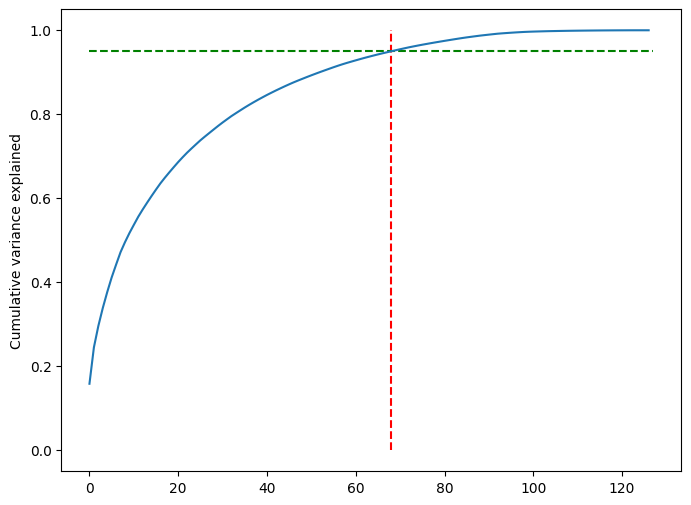

In [75]:
# Lets make a Scree plot for the explained variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[8,6])
plt.vlines(x=68, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=127, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Looks like around 65-70 components would be reqyired to explain around 95% of the variance in the model

In [85]:
#Consider features contributing to 95% variance
pca2 = PCA(0.95)
pca_components2 = pca2.fit_transform(X_train_model1)

In [87]:
# Build a Logistics Regression Base Model on this PCA

logreg = LogisticRegression(random_state=42)
model1 = logreg.fit(pca_components2, y_train_model1)

In [88]:
# Get accuracy score of this model
model1.score(pca_components2, y_train_model1)

0.8472479983031974

In [89]:
# Predict on train dataset
y_train_pca2_pred = model1.predict(pca_components2)

In [90]:
print(classification_report(y_train_model1, y_train_pca2_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     50291
           1       0.77      0.77      0.77     25145

    accuracy                           0.85     75436
   macro avg       0.83      0.83      0.83     75436
weighted avg       0.85      0.85      0.85     75436



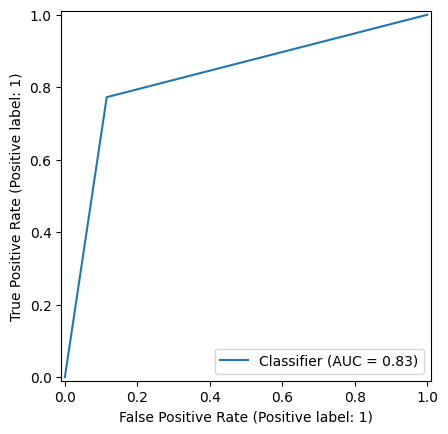

In [92]:
# Plot an ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_train_model1, y_train_pca2_pred)
plt.show()

In [93]:
confusion_matrix(y_train_model1, y_train_pca2_pred)

array([[44487,  5804],
       [ 5719, 19426]])

Lets use an ensemble technique like RandomForest to see if the scoring improves



In [111]:
len(pca.components_)

127

In [113]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1, oob_score=True)
model2 = rf.fit(pca_components2, y_train_model1)

In [114]:
y_train_rf_predict = model2.predict(pca_components2)

In [116]:
print(classification_report(y_train_model1, y_train_rf_predict))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     50291
           1       0.83      0.50      0.63     25145

    accuracy                           0.80     75436
   macro avg       0.81      0.73      0.74     75436
weighted avg       0.80      0.80      0.78     75436



In [106]:
# rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# params = {
#     "criterion": ['gini', 'entropy'],
#     'max_depth': [2, 5,10, 15, 20, 25],
#     'n_estimators': [10, 30, 50, 100, 200]
# }
# scoring = {'accuracy' : make_scorer(accuracy_score), 
#            'precision' : make_scorer(precision_score),
#            'recall' : make_scorer(recall_score), 
#            'f1_score' : make_scorer(f1_score)}

# folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
# model2 = GridSearchCV(estimator=rf, cv=folds, param_grid=params, scoring=scoring, refit='accuracy', n_jobs=-1, verbose=1)

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)